In [1]:
import requests
import zipfile
import os
from matplotlib import pyplot as plt
import numpy as np

import mne
from mne.channels import make_standard_montage
from mne.io import read_raw_cnt

from betaburst.detection.burst_detection import TfBursts

## Download data from the Zhou dataset
[1] Zhou B, Wu X, Lv Z, Zhang L, Guo X (2016) A Fully Automated Trial Selection Method for Optimization of Motor Imagery Based Brain-Computer Interface. PLoS ONE 11(9). https://doi.org/10.1371/journal.pone.0162657

In [2]:
data_path = "https://ndownloader.figshare.com/files/3662952"

zip_file_path = "zhou_data.zip"
extract_folder = "zhou_data"

# Download the compressed archive
response = requests.get(data_path)
with open(zip_file_path, "wb") as file:
    file.write(response.content)

# Decompress the archive in extract folder
os.makedirs(extract_folder, exist_ok=True)
with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    zip_ref.extractall(extract_folder)
os.remove(zip_file_path)

print(f"File downloaded and extracted to {extract_folder}")

File downloaded and extracted to zhou_data


### Read data and extract epochs using [MNE](https://mne.tools/dev/) toolbox
We will load data only from a single subject and a single session.

In [3]:
subject = 2
session = "1A"
fname = f".\\zhou_data\\data\\S{subject}_{session}.cnt"
raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])
stim = raw.annotations.description.astype(np.dtype("<10U"))
stim[stim == "1"] = "left_hand"
stim[stim == "2"] = "right_hand"
stim[stim == "3"] = "feet"
raw.annotations.description = stim
raw.set_montage(make_standard_montage("standard_1005"))
fs = raw.info["sfreq"]

Reading 0 ... 227539  =      0.000 ...   910.156 secs...


C:\Users\ludov\AppData\Local\Temp\ipykernel_748\2373179691.py:4: RuntimeWarning: Could not define the number of bytes automatically. Defaulting to 2.
  raw = read_raw_cnt(fname, preload=True, eog=["VEOU", "VEOL"])


#### Notch filtering to remove line noise artifacts

In [4]:
raw.notch_filter(freqs=[50])
raw.filter(l_freq=None, h_freq=120)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 122.50 Hz)
- Filter length: 

<RawCNT | S2_1A.cnt, 16 x 227540 (910.2 s), ~27.8 MB, data loaded>

#### Create epochs

In [5]:
event_id = {"left_hand": 1, "right_hand": 2}

# Keep only left/right hand motor imagery trials
events, _ = mne.events_from_annotations(raw, event_id=event_id)

# Create the epochs object
tmin, tmax = -1, 7
epochs = mne.Epochs(
    raw, events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=(-1, 0), preload=True
)
print(epochs)

Used Annotations descriptions: ['left_hand', 'right_hand']
Not setting metadata
50 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 50 events and 2001 original time points ...
0 bad epochs dropped
<Epochs |  50 events (all good), -1 – 7 s, baseline -1 – 0 s, ~12.2 MB, data loaded,
 'left_hand': 25
 'right_hand': 25>


In [6]:
times = epochs.times
# Keep only C3 electrode to speed up computations
c3_pos = np.where(np.array(epochs.ch_names) == "C3")[0][0]
trials = epochs.get_data(copy=True)[:, c3_pos, :]
trials = trials[:, np.newaxis, :-1]
fs = epochs.info["sfreq"]

### Superlet Time-Frequency decomposition
1. Set the max frequency (*max_freq* variable)
2. Create an array of frequencies of interest (*foi* variable) and create scales used by the superlet algorithm
3. Apply the superlet TF decomposition algorithm
    * from our testing, the max order of 40, and 4 cycles work well with burst activity in beta range
    * adaptive version of algorithm is mandatory
4. Extract the absolute value (power) from the results
5. Converting to a single precision float may help with memory and storage issues for big datasets

The TF decomposed dataset has, **trials x frequency points x time** dimensions

### Defining the frequency range for the burst detection
Variable *search_range* defines a space in frequency dimension in which bursts are going to be detected and corresponds to the indices in the *foi* variable. The range is 3 Hz wider than frequency range of interest (variable *beta_lims*) to avoid the edge effect, where bursts on the edge of the frequency of interest may be rejected or the TF might be incomplete. Only the bursts with peak frequency within *beta_lims* are going to be kept.

see: https://github.com/danclab/burst_detection#burst-detection-algorithm---usage-notes

The *search_range* selected aperiodic spectrum has to be reshaped to match the frequency dimension of the TF trials. 

In [7]:
# Burst detection parameters
max_freq = 45
foi = np.linspace(1, max_freq, 90)
freqs = foi
upto_gamma_band = np.array([8, 40])
upto_gamma_range = np.where(
    np.logical_and(freqs >= upto_gamma_band[0], freqs <= upto_gamma_band[1])
)[0]

bm = TfBursts(
    fs,
    tmin=tmin,
    tmax=tmax,
    freqs=freqs,
    fr_band=upto_gamma_band,
    band_search_range=upto_gamma_range,
    band_limits=[8, 10, 35],
    remove_fooof=False,
)

In [8]:
tf_trials = bm._apply_tf(trials, order_max=40, c_1=4)

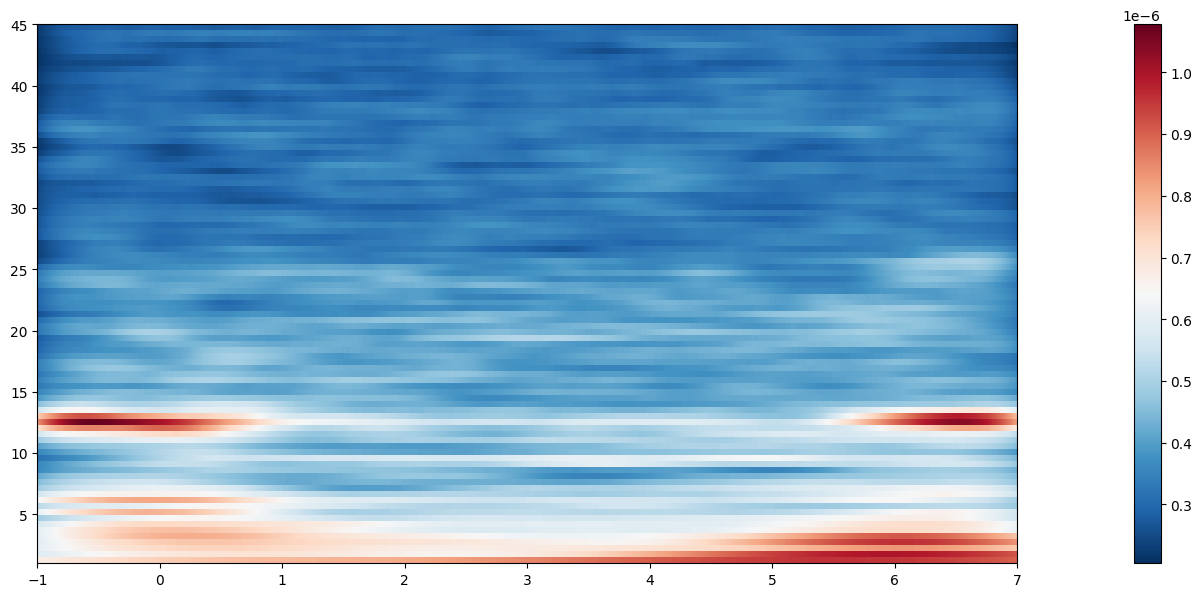

In [16]:
av_psds = np.mean(tf_trials, axis=0)
plt.figure(figsize=(30, 7))
plt.imshow(
    av_psds[0, :, :],
    aspect=1 / 10,
    cmap="RdBu_r",
    interpolation="none",
    origin="lower",
    extent=[tmin, tmax, freqs[0], freqs[-1]],
)
plt.colorbar()

### BURST EXTRACTION

In [10]:
bursts = bm.burst_extraction(trials, band="beta", std_noise=2, regress_ERF=False)[0]

Initiating beta band burst extraction without aperiodic activity subtraction...
	Burst extraction for all channels: from 10 to 35 Hz.


In [11]:
bursts.keys()

dict_keys(['channel', 'trial', 'waveform', 'peak_freq', 'peak_amp_iter', 'peak_amp_base', 'peak_time', 'peak_adjustment', 'fwhm_freq', 'fwhm_time', 'polarity', 'volume', 'waveform_times'])

Text(0.5, 1.0, 'Burst Duration')

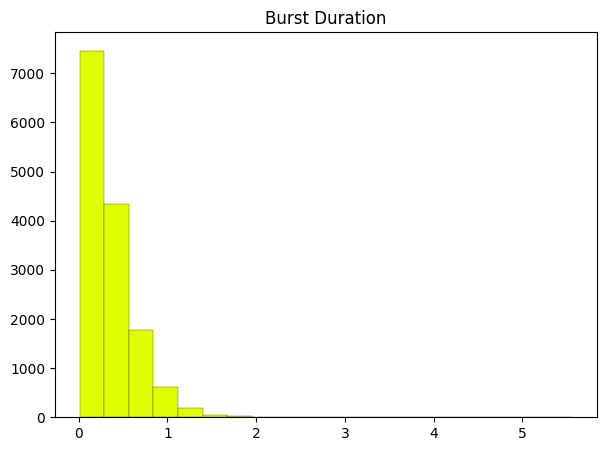

In [12]:
f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(bursts["fwhm_time"], bins=20, color="#DFFF00", edgecolor="black", linewidth=0.2)
ax.set_title("Burst Duration")

Text(0.5, 1.0, 'Frequency Span')

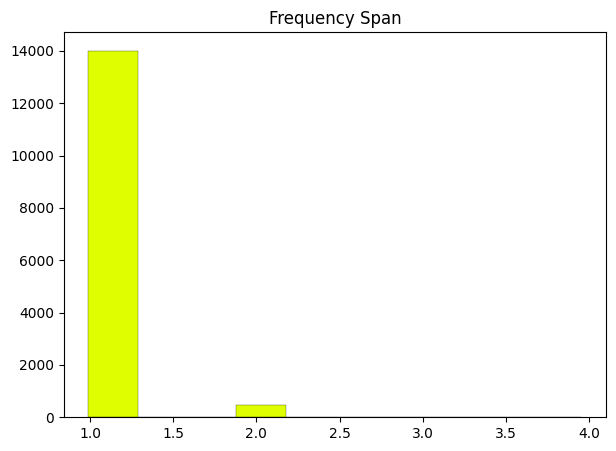

In [13]:
f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(bursts["fwhm_freq"], bins=10, color="#DFFF00", edgecolor="black", linewidth=0.2)
ax.set_title("Frequency Span")

Text(0.5, 1.0, 'Peak Amplitude')

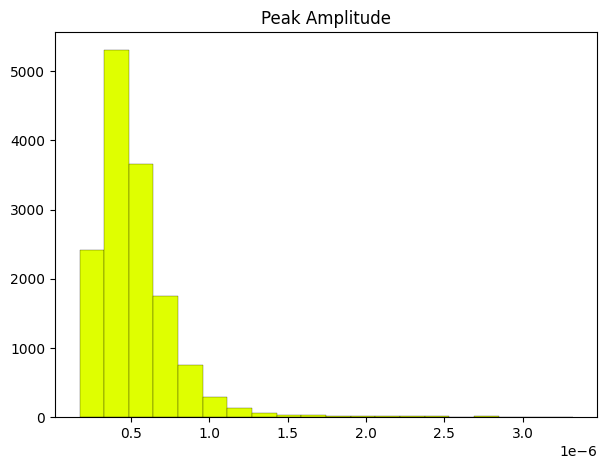

In [14]:
f, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.hist(
    bursts["peak_amp_base"], bins=20, color="#DFFF00", edgecolor="black", linewidth=0.2
)
ax.set_title("Peak Amplitude")

#### Plot the bursts with the bigger amplitude

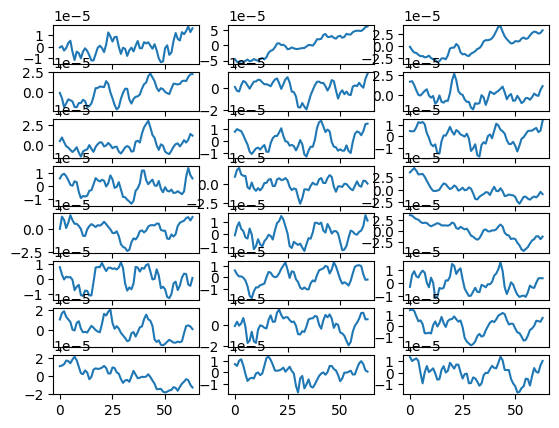

In [15]:
bigger = np.argsort(bursts["peak_amp_iter"])[::-1][:24]
nb_bursts = len(bursts["waveform"])

for idx, burst in enumerate(bursts["waveform"][bigger]):
    plt.subplot(8, 3, idx + 1)
    plt.plot(burst)